In [11]:
from glob import glob
import os
import cv2
from cv2 import imread
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import savemat
from tqdm import tqdm

from SegmentIris import SegmentIris
from IrisNormalization import IrisNormalization
from EncoderIris import EncoderIris
from MatchingTemplate import MatchingTemplate

In [2]:
datasetDir = "./CASIA1/*"
DATABASE_PATH = './templates/'
files = glob(os.path.join(datasetDir, "*_1_*.jpg"))
IMAGE_INPUT = files[10]

In [3]:
def plot_images(images, titles=None, cols=3):  
    """  
    Hiển thị nhiều hình ảnh trong một lưới.  
    
    Parameters:  
    - images: Danh sách các hình ảnh để hiển thị.  
    - titles: Danh sách các tiêu đề tương ứng với hình ảnh (tùy chọn).  
    - cols: Số cột trong lưới (mặc định là 3).  
    """  
    n_images = len(images)  
    rows = (n_images + cols - 1) // cols  # Tính số hàng cần thiết  

    plt.figure(figsize=(15, 5 * rows))  # Thiết lập kích thước hình ảnh  

    for i in range(n_images):  
        plt.subplot(rows, cols, i + 1)  # Tạo subplot cho từng hình ảnh  
        plt.imshow(images[i], cmap='gray')  
        if titles is not None:  
            plt.title(titles[i])  # Thêm tiêu đề nếu có  
        plt.axis('off')  # Tắt trục  

    plt.tight_layout()  # Tối ưu hóa khoảng cách giữa các hình  
    plt.show()  # Hiển thị hình ảnh 
    
def draw_eyelid_contours(eye_image, ciriris, cirpupil, imwithnoise):  
    """  
    Vẽ đường biên của móng mắt trên hình ảnh mắt.  
    
    Parameters:  
    - eye_image: Hình ảnh mắt gốc.  
    - ciriris: Thông tin về đường biên của iris (row, col, radius).  
    - cirpupil: Thông tin về đường biên của pupil (row, col, radius).  
    - imwithnoise: Hình ảnh đã loại bỏ mi và có cận trên, cận dưới của mí mắt.  
    """  

    # Vẽ đường biên của iris  
    iris_row, iris_col, iris_radius = ciriris  
    iris_circle = plt.Circle((iris_col, iris_row), iris_radius, color='blue', fill=False, linewidth=2)  
    
    # Vẽ đường biên của pupil  
    pupil_row, pupil_col, pupil_radius = cirpupil  
    pupil_circle = plt.Circle((pupil_col, pupil_row), pupil_radius, color='red', fill=False, linewidth=2)  

    # Tạo mặt nạ cho vùng bên trong của iris và pupil  
    mask_inner = np.zeros_like(imwithnoise, dtype=bool)  
    y, x = np.ogrid[:imwithnoise.shape[0], :imwithnoise.shape[1]]  
    
    # Mặt nạ cho iris  
    iris_mask = (x - iris_col) ** 2 + (y - iris_row) ** 2 <= iris_radius ** 2  
    mask_inner |= iris_mask  
    
    # Mặt nạ cho pupil  
    pupil_mask = (x - pupil_col) ** 2 + (y - pupil_row) ** 2 <= pupil_radius ** 2  
    mask_inner |= pupil_mask  

    # Áp dụng mặt nạ để giữ lại các vùng bên trong  
    # thay thế các vùng bên ngoài bằng NaN  
    image_inner = np.where(mask_inner, imwithnoise, np.nan)  

    return image_inner

# Dành cho việc chạy từng ảnh
## 1. Phân loại mống mắt và loại bỏ mi (noise)

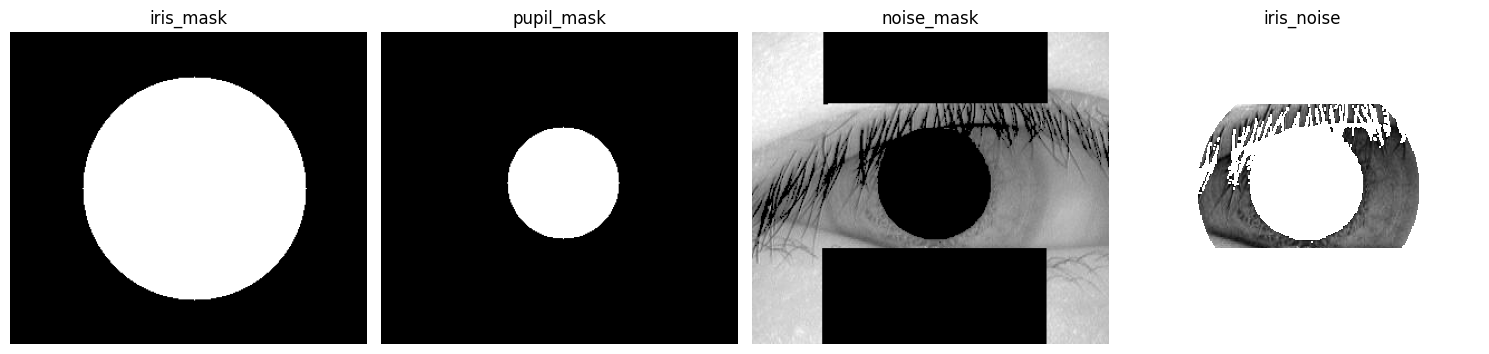

In [4]:
eyelashes_threshold = 80
multiprocess = False
#  segmentation
im = imread(IMAGE_INPUT, 0)
iris_segmenter = SegmentIris()
ciriris, cirpupil, imwithnoise = iris_segmenter.segment(im, eyelashes_threshold,  multiprocess)

# Tạo hình ảnh cho mống mắt
iris_image = np.zeros_like(im, dtype=np.uint8)
cv2.circle(iris_image, (ciriris[1], ciriris[0]), ciriris[2], (255), thickness=-1)
# Tạo hình ảnh cho đồng tử
pupil_image = np.zeros_like(im, dtype=np.uint8)
cv2.circle(pupil_image, (cirpupil[1], cirpupil[0]), cirpupil[2], (255), thickness=-1) 

noise_image = imwithnoise.astype(np.uint8)
a = draw_eyelid_contours(im, ciriris, cirpupil, imwithnoise)
images = [iris_image, pupil_image, noise_image, a] 
plot_images(images, titles=['iris_mask', 'pupil_mask', 'noise_mask', 'iris_noise'], cols=4)


## 2. Chuẩn hóa móng mắt về vector đặc trưng

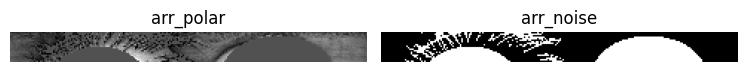

In [5]:
radial_resolution = 20
angular_resolution = 240
# normalization
iris_normalizer = IrisNormalization()
arr_polar, arr_noise = iris_normalizer.normalize(imwithnoise, ciriris[1],  ciriris[0], ciriris[2],
                                         cirpupil[1], cirpupil[0], cirpupil[2],
                                         radial_resolution, angular_resolution)
arr_polar_image = (arr_polar * 255).astype(np.uint8)
arr_noise_image = (arr_noise.astype(np.uint8) * 255)
images = [arr_polar_image, arr_noise_image] 
plot_images(images, titles=['arr_polar', 'arr_noise'], cols=4)

## 3. Encode vector đặc trưng

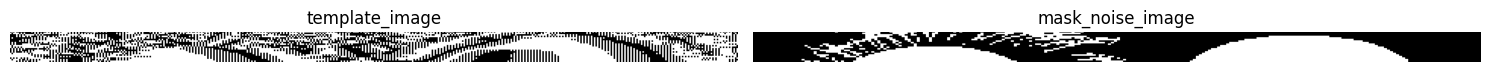

In [6]:
minw_length = 18
mult = 1
sigma_f = 0.5
#  feature encoding
encoder_iris = EncoderIris() 
template, mask_noise = encoder_iris.encode_iris(arr_polar, arr_noise, minw_length, mult, sigma_f)

mask_noise_image = (mask_noise * 255).astype(np.uint8) 
template_image = (template * 255).astype(np.uint8)

images = [template_image, mask_noise_image ] 
plot_images(images, titles=['template_image','mask_noise_image'], cols=2)

## 4. Lưu vector encoder để tiện cho việc so sánh

In [7]:
basename = os.path.basename(IMAGE_INPUT)
out_file = os.path.join(DATABASE_PATH, "%s.mat" % (basename))
if not os.path.exists(DATABASE_PATH):
    print("makedirs", DATABASE_PATH)
    os.makedirs(DATABASE_PATH)
savemat(out_file, mdict={'template': template, 'mask': mask_noise})

## 5. Testing

In [8]:
def extractFeature(img_filename, eyelashes_threshold=80, multiprocess=True):
    """
    Extract features from an iris image
    """
    iris_segmenter = SegmentIris()
    iris_normalizer = IrisNormalization()
    encoder_iris = EncoderIris()  
    # parameters
    eyelashes_threshold = 80
    radial_resolution = 20
    angular_resolution = 240
    minw_length = 18
    mult = 1
    sigma_f = 0.5

    #  segmentation
    im = imread(img_filename, 0)
    ciriris, cirpupil, imwithnoise = iris_segmenter.segment(im, eyelashes_threshold,
                                    multiprocess)
    #draw_iris_boundaries(im, ciriris, cirpupil, imwithnoise)
    # normalization
    arr_polar, arr_noise = iris_normalizer.normalize(imwithnoise, ciriris[1],  ciriris[0], ciriris[2],
                                         cirpupil[1], cirpupil[0], cirpupil[2],
                                         radial_resolution, angular_resolution)

    #  feature encoding
    template, mask_noise = encoder_iris.encode_iris(arr_polar, arr_noise, minw_length, mult, sigma_f)
   
    return template, mask_noise, img_filename

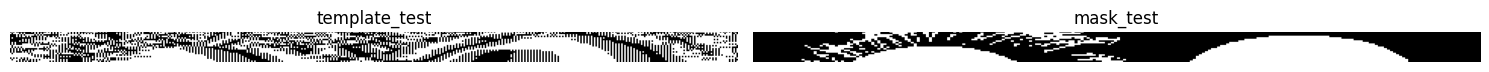

['101_1_2.jpg.mat']
	samples found (desc order of reliability):
	 101_1_2.jpg.mat


In [9]:
template_test, mask_test, _ = extractFeature(files[10], multiprocess=False)
images = [template_test, mask_test ] 
plot_images(images, titles=['template_test','mask_test'], cols=2)
matcher = MatchingTemplate()
result = matcher.matchingTemplate(template_test, mask_test, DATABASE_PATH, threshold = 0.38)
print(result)
# results 
if result == -1:
    print('\tNo registered sample.')
elif result == 0:
    print('\tNo sample found.')
else:
    print('\tsamples found (desc order of reliability):'.format(len(result)))
    for res in result:
        print("\t", res)

# Dành cho việc chạy hàng loạt
## 1. Tạo danh sách database các mẫu đặc trưng

In [12]:
for file in tqdm(files, desc="Processing files", unit="file"):  
    template, mask_noise, _ = extractFeature(file, multiprocess=False)
    basename = os.path.basename(file)  
    out_file = os.path.join(DATABASE_PATH, "%s.mat" % (basename))  
    if not os.path.exists(DATABASE_PATH):   
        os.makedirs(DATABASE_PATH) 
    savemat(out_file, mdict={'template': template, 'mask': mask_noise})

Processing files: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 324/324 [08:56<00:00,  1.66s/file]


## 2. Tạo tập test đặc trưng

In [ ]:
TEST_PATH = './test/'
test_files = glob(os.path.join(datasetDir, "*_2_*.jpg"))  
for file in tqdm(test_files, desc="Processing files", unit="file"):  
    template_test, mask_test, _ = extractFeature(file, multsiprocess=False)  
    basename = os.path.basename(file)  
    out_file = os.path.join(TEST_PATH, "%s.mat" % (basename))  
    if not os.path.exists(TEST_PATH):   
        os.makedirs(TEST_PATH) 
    savemat(out_file, mdict={'template': template_test, 'mask': mask_test})

Processing files:  43%|███████████████████████████████████████████████████████████████████████▉                                                                                                | 185/432 [05:09<06:29,  1.58s/file]

## 3. Test với nhiều ngưỡng khác nhau tìm ra ngưỡng tốt nhất và đánh giá

In [ ]:
test_files = glob(os.path.join(datasetDir, "*_2_*.jpg")) 
mat_database = glob(os.path.join(DATABASE_PATH, "*.mat"))
print('Tổng số lượng file test: ', len(test_files))  
print('Tổng số lượng sample database: ', len(mat_database)) 
precisions = []
thresholds = [0.25, 0.3, 0.35, 0.4]

results_summary = []  
total_samples = len(mat_database)
for ts in thresholds:  
    print('Threshold: ', ts)  
    true_positives = 0  
    total_matches = 0  
    total_non_matches = 0
    false_positives = 0
    for file in tqdm(os.listdir(TEST_PATH), desc="Loading files", unit="file"):  
        if file.endswith('.mat'):  
            mat_data = sio.loadmat(os.path.join(TEST_PATH, file))  
            template = mat_data['template']  
            mask_noise = mat_data['mask']  

            result = matcher.matchingTemplate(template, mask_noise, DATABASE_PATH, threshold=ts)  
            
            if result == -1:
                print('\tNo registered sample.')
            elif result == 0:
                total_non_matches += 1
            else:
                total_matches += 1
                if file.split('_')[0] == result[0].split('_')[0]:
                    #Khop và mô hình cũng cho là khớp
                    true_positives += 1
                else:
                    #Khong khớp nhưng mô hình cho là khớp
                    false_positives += 1


    # Tính toán Precision 
    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    precisions.append(precision)
    print(f'Precision: {precision:.4f}')  
    print(f'Total Matches: {total_matches}')  
    print(f'Total Non-Matches: {total_non_matches}')
    print(f'Total True Positives: {true_positives}')  
    print(f'Total False Positives: {false_positives}')

In [ ]:
plt.figure(figsize=(10, 6))  
plt.plot(thresholds, precisions)  
plt.xlabel('Threshold')  
plt.ylabel('Precision')  
plt.title('Precision vs Threshold')  
plt.grid()  
plt.show() 